# Climate Change Belief Analysis


by Classification_JS1_DSFT21

# Introduction 
Several companies are built around lessening one’s environmental impact or carbon footprint. This is because they offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, we have created a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data. This model together will the accompanying app will help Geo-Environmental Consultation companies who are turning to social media to obtain valuable information about job applicants and to monitor the activities of their employees in relation to the values they have towards the company's projects and beliefs surrounding the ever changing global environment.

Providing an accurate and robust solution to this task will provide access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies. The app launched on **streamlit** is also an intuitive, easy to use, simple and the customer can rely on the product it.

Authors: John Bosman, Kabelo Mbewe, Khwatsi Hlungwani, Reneilwe Mhahlele, Tshegofatso Letlape and Mathew van Wyk

# Table of Contents

1. Intro to Comet
2. Importing Libraries
3. Importing Dataset
4. Data Preprocessing
5. Exploratory Data Analysis
6. Feature Engineering and Selection

### Comet

Comet is a great tool for model versioning and experimentation as it records the parameters and conditions from each of the experiements- allowing for reproducing of results, or going back to a previous version of the experiment.

In [48]:
pip install comet_ml

In [49]:
# Loading in the comet_ml tool
#from comet_ml import Experiment
    
# Setting the API key, saved as environment variable
# experiment = Experiment(api_key="your api key here",
#                       project_name="current project your are working on", workspace="your workspace name")
# experiment.display()

# Importing Libraries

In [1]:
# Importing modules for data science and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180 # Quality of all figures in notebook
# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from nlppreprocess import NLP

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Importing dataset

In [2]:
# Loading in the datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv('sample_submission.csv')

# Data Preprocessing

# Summary Statistics

In [8]:
# Looking at the predicted output
sample_submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [3]:
# Looking at the first few entries in the dataset
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [10]:
# Shape of the dataset
train.shape

(15819, 3)

In [11]:
# dataframe information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [12]:
# Looking at the numbers of possible classes in our sentiment
train['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [13]:
# Looking at the how the messages are distributed across the sentiment
train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


In [15]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [17]:
# Shape of the dataset
test.shape

(10546, 2)

# Missing values

In [14]:
# Checking for missing values
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

Fortunately, there are no missing values in our dataset.

In [15]:
# Checking whether a character is white-space character or not
print(len(train['message']))
print(sum(train['message'].apply(lambda x: x.isspace())))

15819
0


In [16]:
# Sample tweet
tweet = train.iloc[6,1]
print(tweet)

RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R


Text(0.5, 1.0, 'Distribution of target labels')

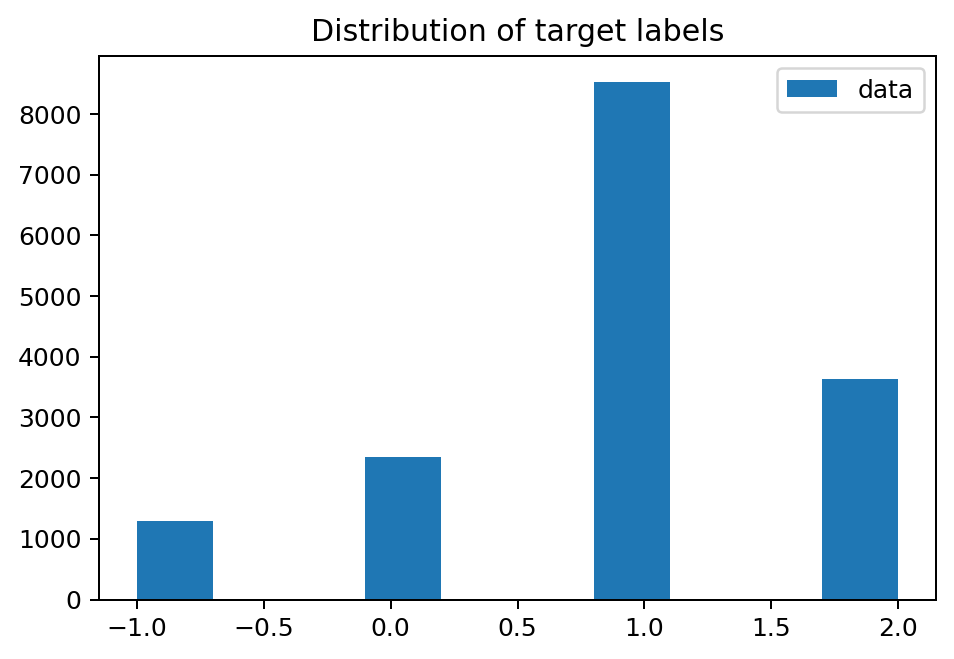

In [17]:
# Visualizing the distribution of the target 
plt.hist(train['sentiment'], label='data');
plt.legend();
plt.title('Distribution of target labels')

It is notable that there is an imbalance of classes in the daset and these tend to be a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. This can cause problems as most algorithms are designed to maximize accuracy and reduce error. Therefore we will address and take care of the class imbalance in our EDA

Text(0, 0.5, 'Density')

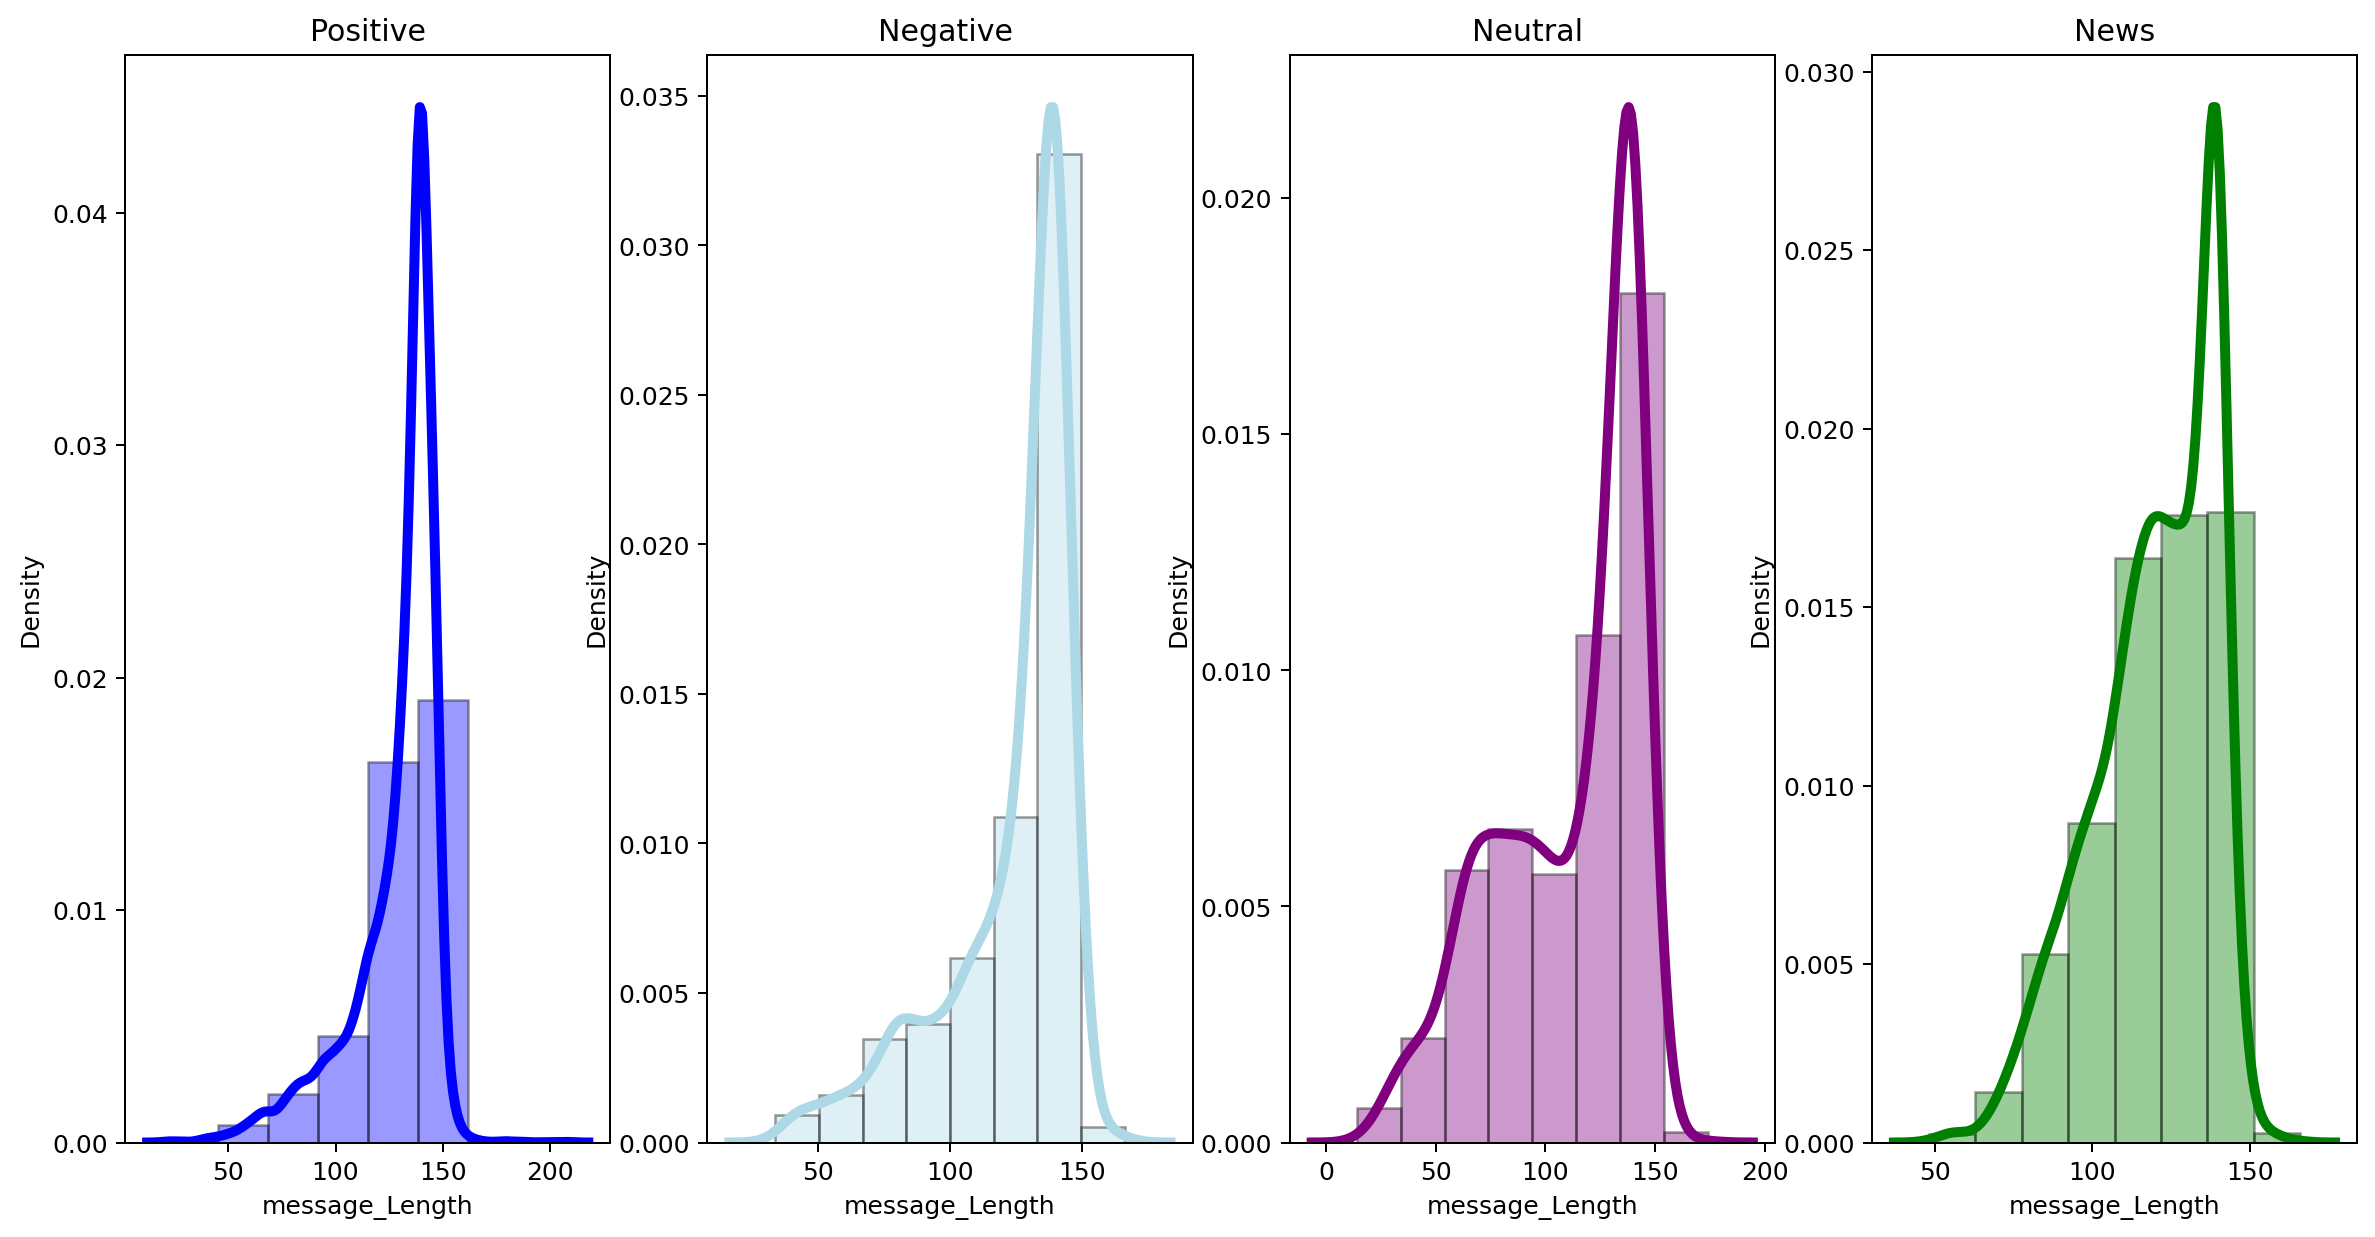

In [18]:
# Distribution plots for the label
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8))

#For Positive 
sns.distplot(train[train['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(train[train['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'lightblue', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(train[train['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'purple',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For Neews
sns.distplot(train[train['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'green', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('News')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')

The average length of messages for all sentiments is not suprising as a tweet is only limited to 140 characters. However, the density contrast between positive and negative sentiments is interesting and will make for more unpacking later in the EDA. Now that we have explored our dataset, we can begin perfoming some analyses on it.

# Exploratory Data Analysis

We perform investigative and detective analysis of our data to see if we can unearth any insights.

In [4]:
working_df = train.copy()
# Labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]

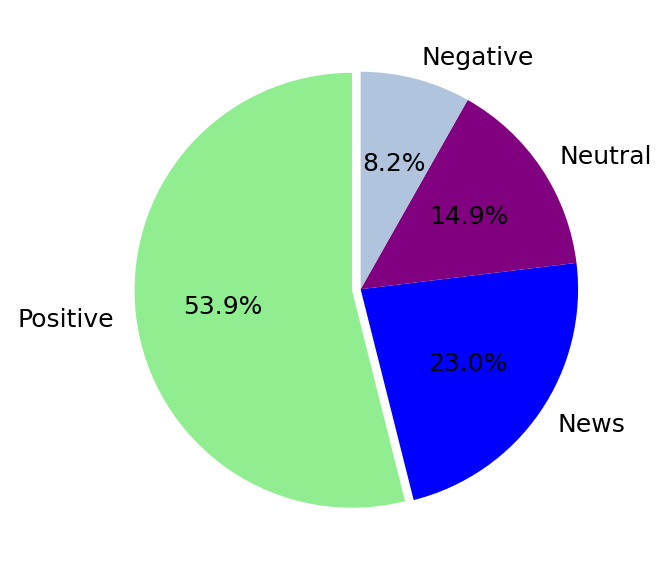

In [20]:
# checking the numerical distribution
values = working_df['sentiment'].value_counts()/working_df.shape[0]
labels = (working_df['sentiment'].value_counts()/working_df.shape[0]).index
colors = ['lightgreen', 'blue', 'purple', 'lightsteelblue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0), colors=colors)
plt.show()

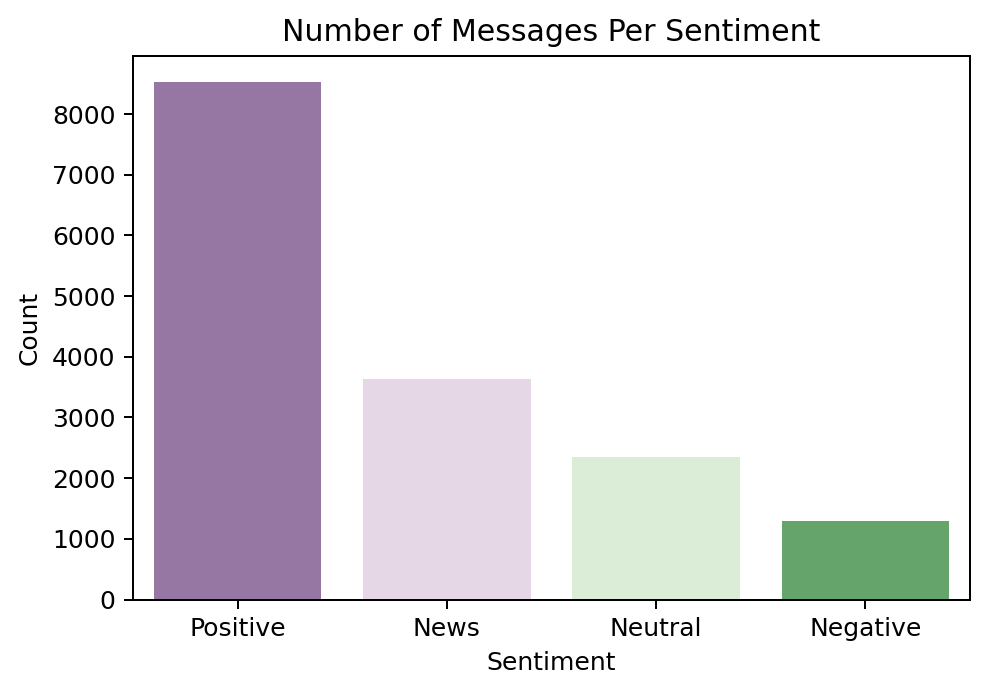

In [21]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Messages Per Sentiment')
plt.show()

As we noted earlier that there is an imbalance of classes in the dataset, this can lead to a disproportionate ratio of observations in each class, causing problems as most algorithms are designed to maximize accuracy and reduce error. We therefore continue to analyse and evaluate for more insights to be derived from the dataset as we prepared to balance later on in the analysis.

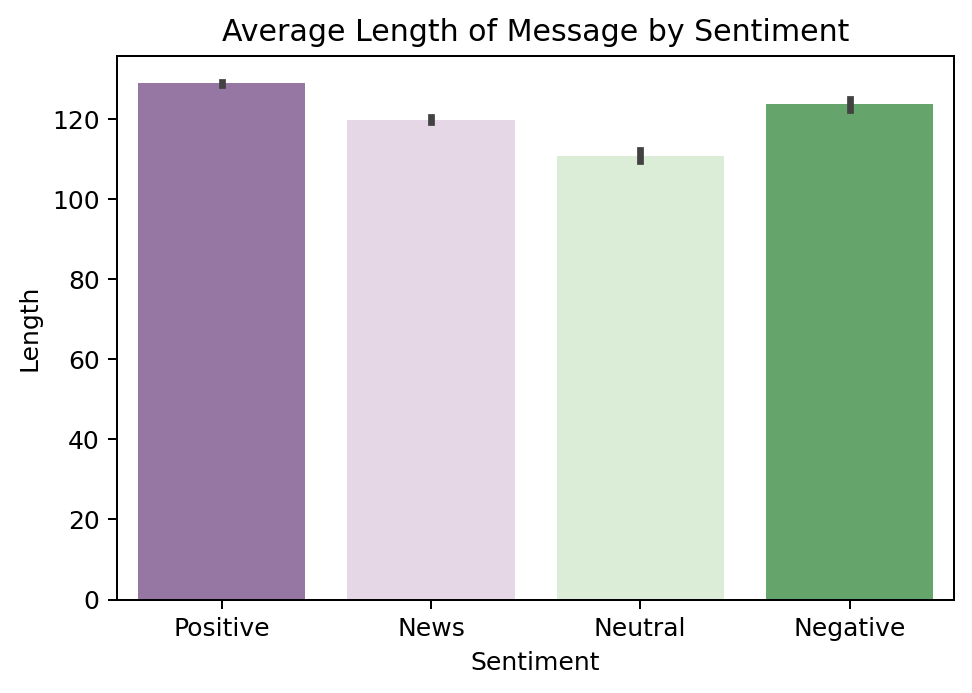

In [22]:
# Visualizing text lengths for each sentiment
sns.barplot(x='sentiment', y=working_df['message'].apply(len) ,data = working_df, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

In [5]:
# Extracting Users in a column
working_df['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in working_df.message]

# Creating a column of hastags
working_df['hashtags'] = [' '.join(re.findall(r'#\w{,}', line)) 
                       if '#' in line else np.nan for line in working_df.message]

In [6]:
# Generating Counts of users
counts = working_df[['message',
                     'users']].groupby('users',
                                       as_index=False).count().sort_values(by='message', ascending=False)

In [7]:
# Top 5 most popular
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


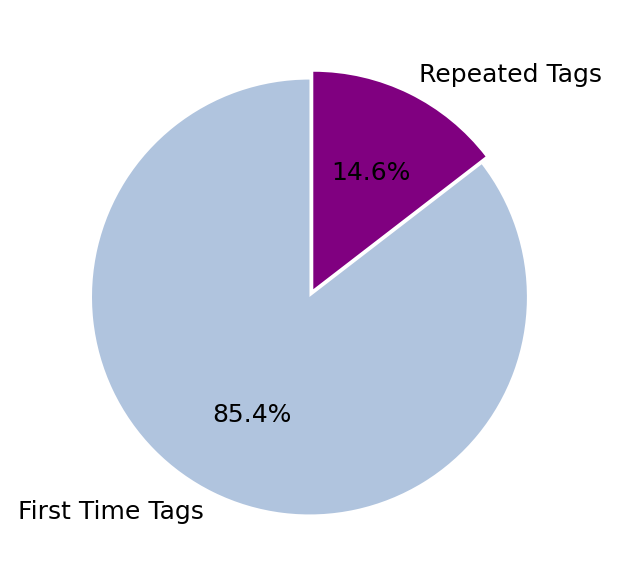

In [26]:
# checking the numerical distribution
values = [sum(np.array(counts['message']) == 1)/len(counts['message']),
          sum(np.array(counts['message']) != 1)/len(counts['message'])]
labels = ['First Time Tags', 'Repeated Tags']
colors = ['lightsteelblue', "purple"]
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0), colors=colors)
plt.show()

In [27]:
repeated_tags_rate = round(sum(np.array(counts['message']) > 1)*100/len(counts['message']), 1)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

14.6 percent of the data are from repeated tags


In [28]:
first_time_tags = round(sum(np.array(counts['message']) == 1)*100/len(counts['message']), 1)
print(f"{first_time_tags} percent of the data are from first time tags")

85.4 percent of the data are from first time tags


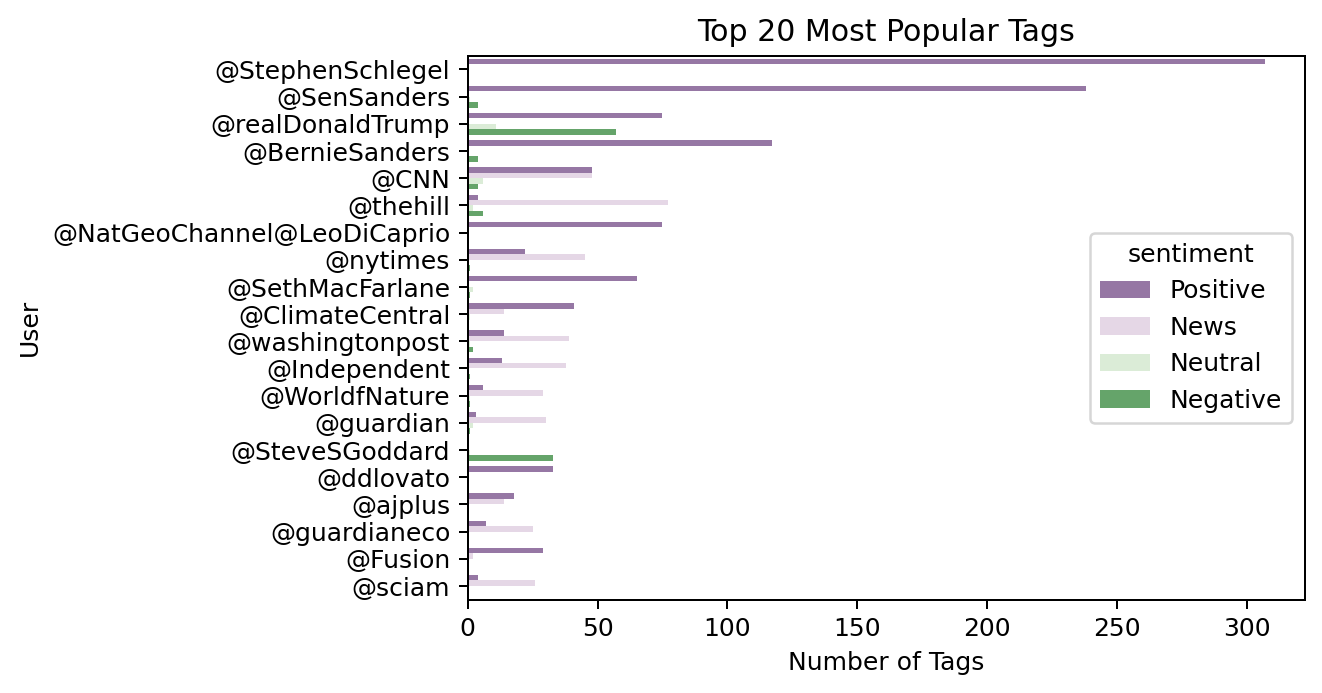

In [29]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(y="users", hue="sentiment", data=working_df, palette='PRGn',
              order=working_df.users.value_counts().iloc[:20].index) 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()

Now that we've had a look at the tweets themselves as well as the users, we now analyse the hastags:

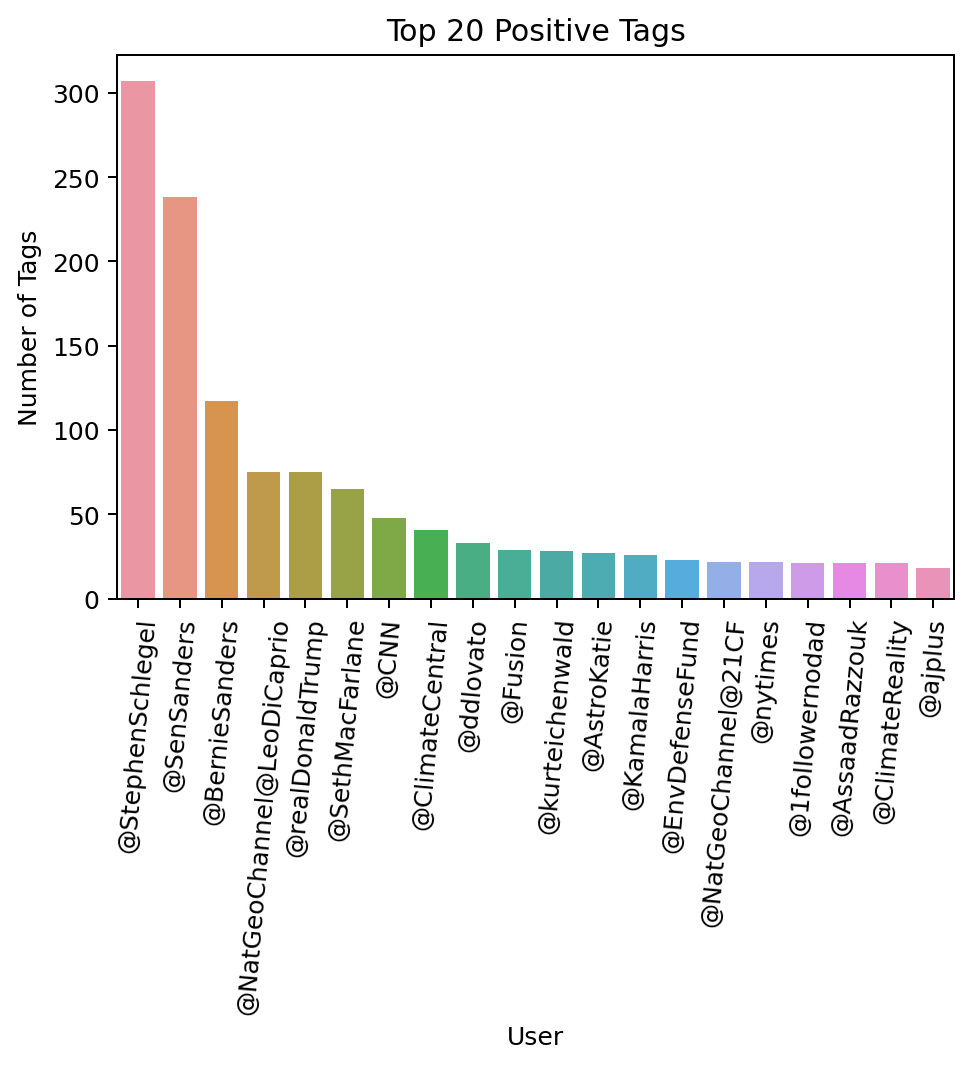

In [31]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Positive'],
              order=working_df[working_df['sentiment'] == 'Positive'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Positive Tags')
plt.xticks(rotation=85)
plt.show()

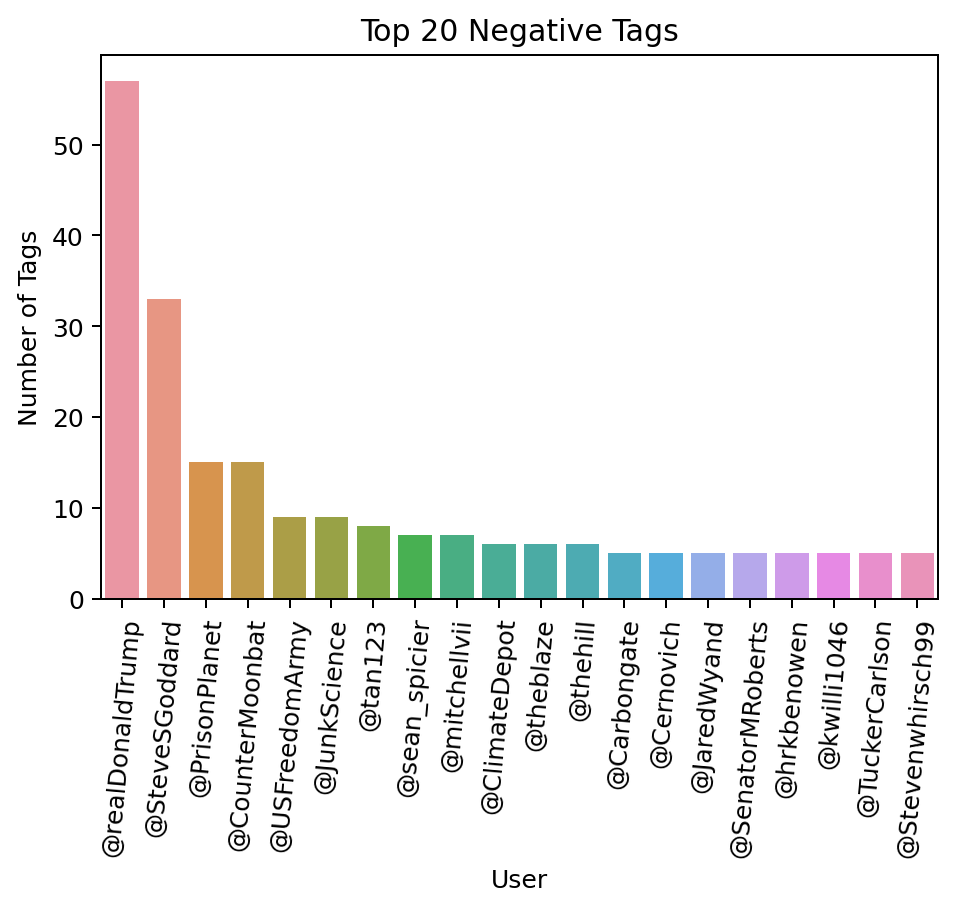

In [30]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Negative'],
              order=working_df[working_df['sentiment'] == 'Negative'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Negative Tags')
plt.xticks(rotation=85)
plt.show()

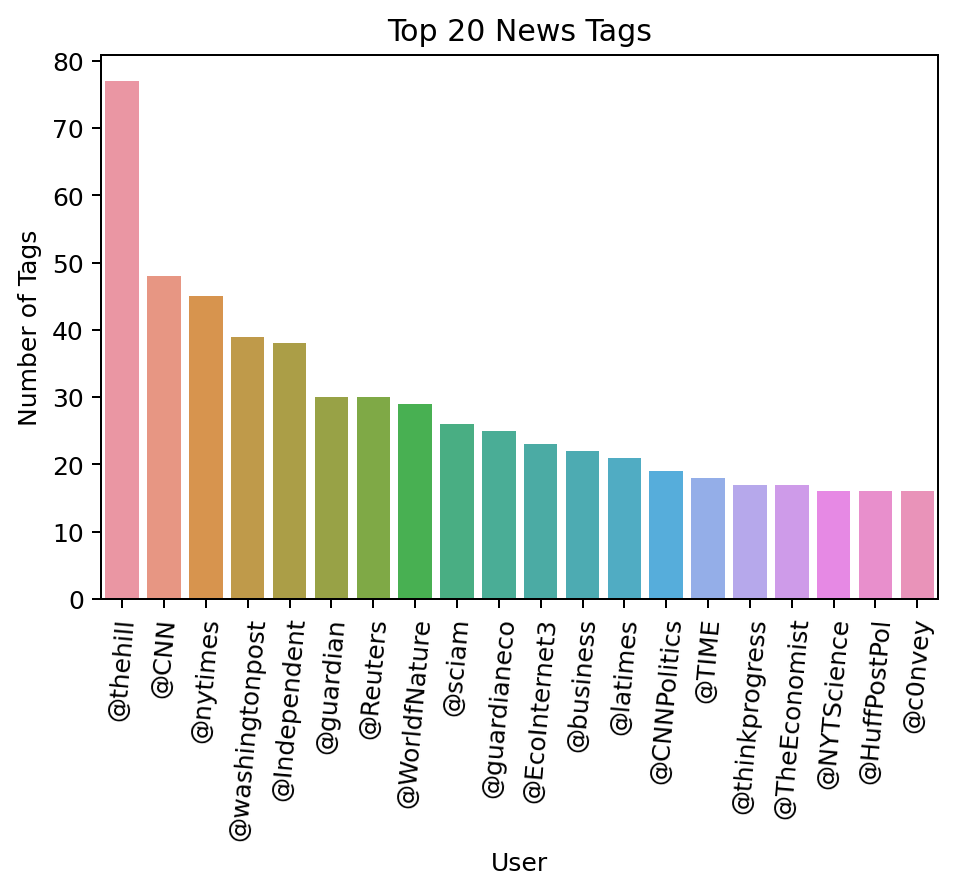

In [32]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'News'],
              order=working_df[working_df['sentiment'] == 'News'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 News Tags')
plt.xticks(rotation=85)
plt.show()

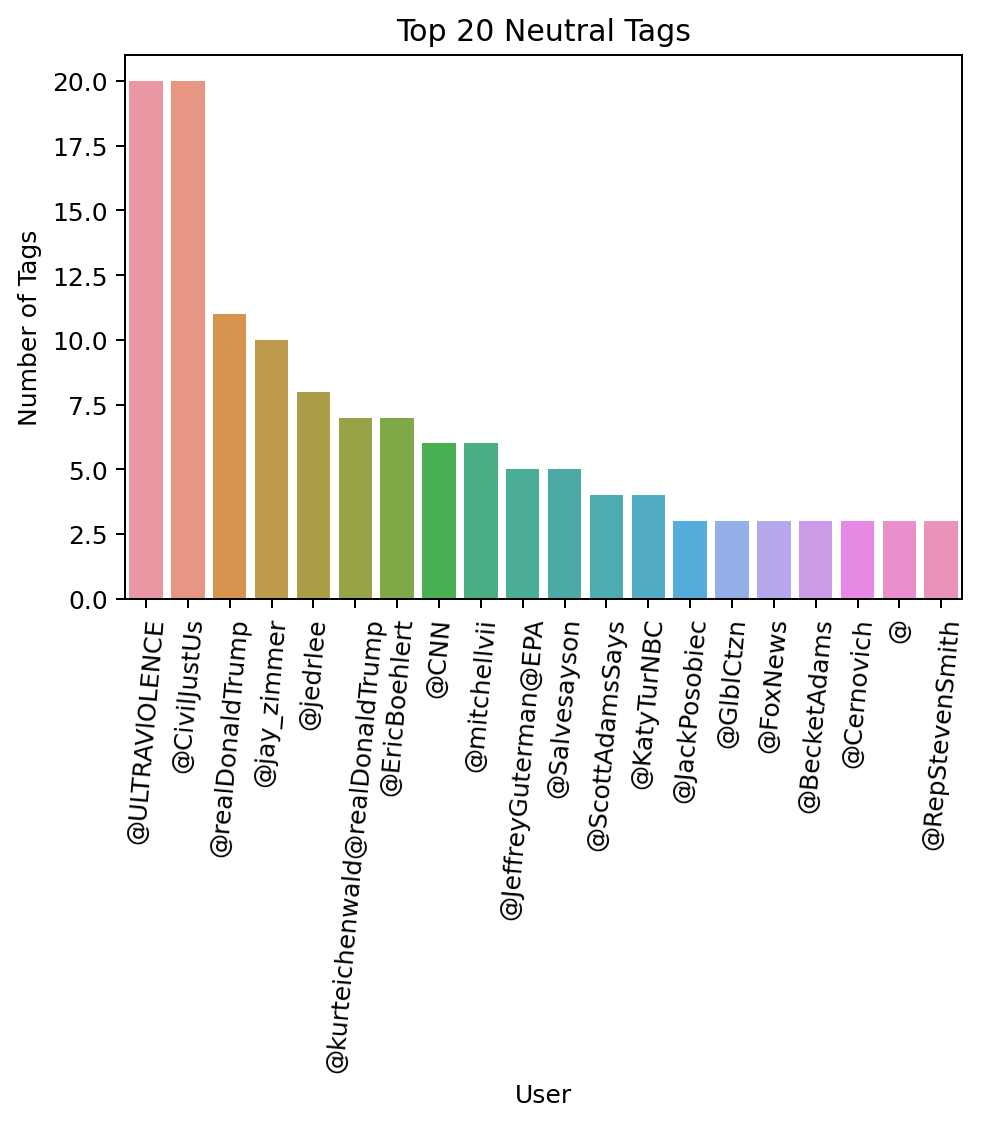

In [33]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Neutral'],
              order=working_df[working_df['sentiment'] == 'Neutral'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Neutral Tags')
plt.xticks(rotation=85)
plt.show()

# Balancing the classes

#### Class size to up/down sample

Resampling is a process which involves changing the frequency of the observations. Below we apply it to assess whether or not it will improve our training. This process also serves as model tuning as we will be using a define resampling strategy while taking note of performance measure.

In [8]:
data = train.copy()

In [9]:
# importing the module and creating a resampling variable
from sklearn.utils import resample
class_size = int(len(data[data['sentiment']==1])/2)

In [10]:
# seperating the four classes
class_1 = data[data['sentiment']==-1]
class_2 = data[data['sentiment']==0]
class_3 = data[data['sentiment']==1]
class_4 = data[data['sentiment']==2]

#### Up-sampling

Here we increase the frequency of the samples.

In [11]:
# upsampling classes 1, 2 & downsampling class 3
class_1_up = resample(class_1,replace=True,n_samples=class_size, random_state=27)
class_2_up = resample(class_2,replace=True,n_samples=class_size, random_state=27)
class_4_up = resample(class_4,replace=True,n_samples=class_size, random_state=27)
class_3_down = resample(class_3,replace=False,n_samples=class_size, random_state=27)

In [12]:
# Creating a new DataFrame out of the balanced bata
res_df = pd.concat([class_1_up, class_2_up, class_4_up, class_3_down])

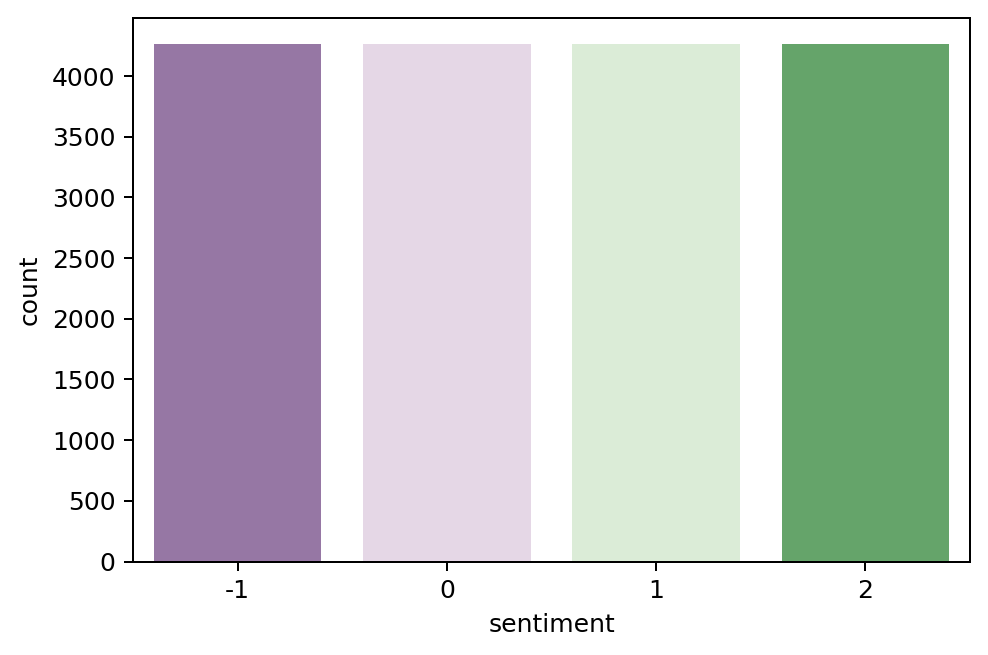

In [39]:
# Checking if data has been well-balanced
sns.countplot(x = res_df['sentiment'], data = data, palette='PRGn')
plt.show()

## Cleaning text data:

In [13]:
df_train = res_df.copy() #creating copy of dataset to clean

stop_words = set(stopwords.words('english')) #creating list of stop words to be removed
stop_words |= {'global', 'warming', 'climate', 'change', 'u'} #adding common terms to stop words
pattern = r'(\S*https?:\S*)|(@\w+)|(#\w+)' #creating patterns to be removed '@handle', '#handle' and urls ('http://')
df_train['internet_remove'] = df_train.message.str.replace(pattern, '') #removing pattern defined elements
df_train['internet_remove'] = df_train.internet_remove.str.replace('RT : ', ' ') #removing retweet ('RT :')
df_train['internet_remove'] = df_train.internet_remove.str.replace('\n', ' ') #removing '\n'
df_train['internet_remove'] = df_train['internet_remove'].str.lower() #converting all strings to lowercase
df_train['clean_txt'] = df_train['internet_remove'].str.replace('[^\w\s]', ' ') #removing punctuation
df_train['clean_txt'] = df_train['clean_txt'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) #removing stop words

df_train['clean_txt'] = df_train['clean_txt'].apply(lambda x: re.sub('\w*\d\w*','', x)) #removing digits
df_train = df_train.drop(['message', 'internet_remove'], axis = 1) #dropping old unnecessary columns

df_train.head()

,sentiment,tweetid,clean_txt
12819,-1,69529,fake
6687,-1,316086,govt controls scientific research via grant mo...
9172,-1,106644,trump veers script one reversal another alt ri...
12863,-1,527580,going start replacing chemosh headlines times...
1878,-1,477516,aint believing bunk


In [39]:
df_test = test.copy()

stop_words = set(stopwords.words('english')) #creating list of stop words to be removed
stop_words |= {'global', 'warming', 'climate', 'change', 'u'} #adding common terms to stop words
pattern = r'(\S*https?:\S*)|(@\w+)|(#\w+)' #creating patterns to be removed '@handle', '#handle' and urls ('http://')
df_test['internet_remove'] = df_test.message.str.replace(pattern, '') #removing pattern defined elements
df_test['internet_remove'] = df_test.internet_remove.str.replace('RT : ', ' ') #removing retweet ('RT :')
df_test['internet_remove'] = df_test.internet_remove.str.replace('\n',' ') #removing '\n'
df_test['internet_remove'] = df_test['internet_remove'].str.lower() #converting all strings to lowercase
df_test['clean_txt'] = df_test['internet_remove'].str.replace('[^\w\s]',' ') #removing punctuation
df_test['clean_txt'] = df_test['clean_txt'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) #removing stop words
df_test['clean_txt'] = df_test['clean_txt'].apply(lambda x: re.sub('\w*\d\w*','', x)) #removing digits
df_test = df_test.drop(['message', 'internet_remove'], axis = 1) #dropping old unnecessary columns

df_test.head()

,tweetid,clean_txt
0,169760,europe looking china make sure alone fighting
1,35326,combine polling staffers womens rights fascist...
2,224985,scary unimpeachable evidence already
3,476263,putin got jill trump believe thinks hoax
4,872928,female orgasms cause sarcastic republican


Seperating sentiments to create word clouds to the most common words associated with each type of opinion:

In [18]:
df_pos = df_train.loc[df_train['sentiment'] == 1] #positive reviews
df_neg = df_train.loc[df_train['sentiment'] == -1] #negative reviews
df_neu = df_train.loc[df_train['sentiment'] == 0] #neutral reviews
df_new = df_train.loc[df_train['sentiment'] == 2] #news reviews

In [19]:
pos_string = df_pos['clean_txt'].str.cat(sep = ' ')
neg_string = df_neg['clean_txt'].str.cat(sep = ' ')
neu_string = df_neu['clean_txt'].str.cat(sep = ' ')
new_string = df_new['clean_txt'].str.cat(sep = ' ')

Positive WordCloud:

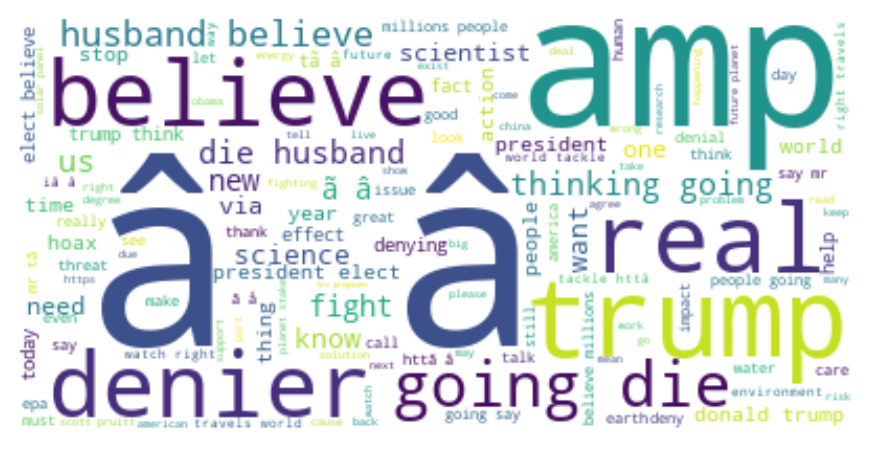

In [44]:
pos_cloud = WordCloud(background_color='white').generate(pos_string) #creating and generating word cloud image 
plt.imshow(pos_cloud, interpolation='bilinear') #displaying the generated wordcloud image
plt.axis("off")
plt.show()

Negative WordCloud:

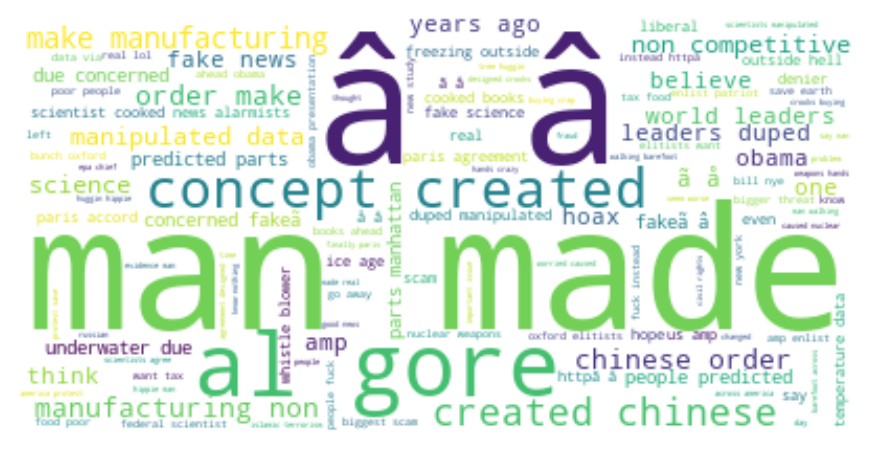

In [45]:
neg_cloud = WordCloud(background_color='white').generate(neg_string) #creating and generating word cloud image 
plt.imshow(neg_cloud, interpolation='bilinear') #displaying the generated wordcloud image
plt.axis("off")
plt.show()

Neutral WordCloud:

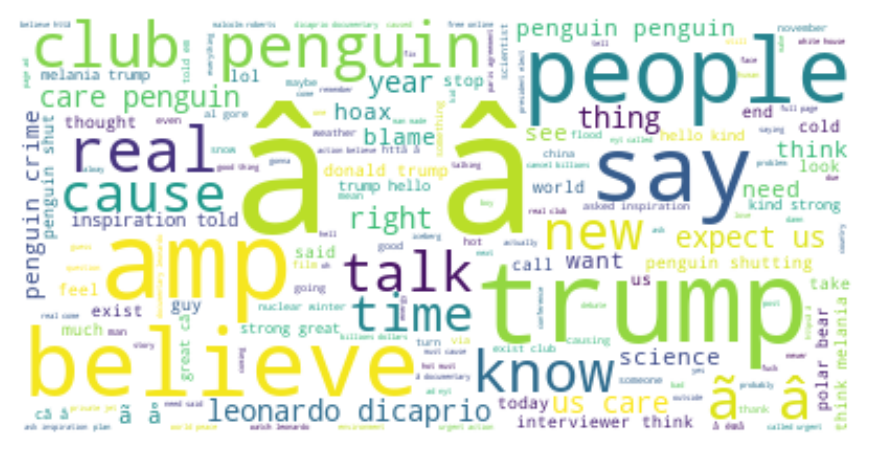

In [46]:
neu_cloud = WordCloud(background_color='white').generate(neu_string) #creating and generating word cloud image 
plt.imshow(neu_cloud, interpolation='bilinear') #displaying the generated wordcloud image
plt.axis("off")
plt.show()

News WordCloud:

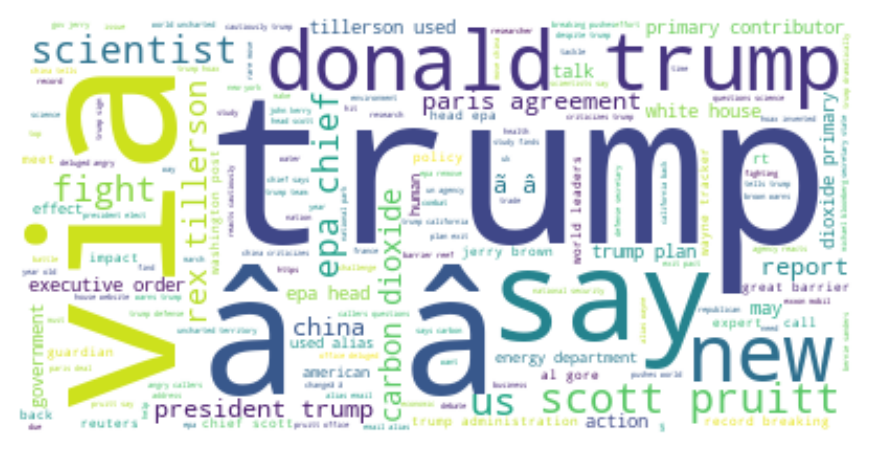

In [47]:
new_cloud = WordCloud(background_color='white').generate(new_string) #creating and generating word cloud image 
plt.imshow(new_cloud, interpolation='bilinear') #displaying the generated wordcloud image
plt.axis("off")
plt.show()

Creating Lemmatizer Function:

In [20]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, text):
        return [self.wnl.lemmatize(t) for t in word_tokenize(text)]

TfidfVectorizer:

In [64]:
vect = TfidfVectorizer(ngram_range=(3,3), max_features = 166, min_df = 10, strip_accents = 'unicode', tokenizer = LemmaTokenizer(), stop_words = stop_words) #building and fitting the vectorizer

X_clean_txt = vect.fit_transform(df_train.clean_txt) #transforming the 'clean_txt' column

df_features = pd.DataFrame(X_clean_txt.toarray(), columns=vect.get_feature_names()) #creating the features dataset

df_features.head()

,across america protest,agency reacts cautiously,ahead obama presentation,alias wayne tracker,america protest save,anemone crack ice,angry caller question,arctic sea ice,asked inspiration told,barefoot across america,...,watch leonardo dicaprio,watch right travel,weapon hand crazy,whistle blower charge,white house website,world leader duped,world tackle htta,world uncharted territory,worried caused nuclear,would underwater due
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Use these values for 'X' and 'y' in 'train_test_split':

In [66]:
y = df_train['sentiment']
X = df_features

Place all modeling code **below** here:

In [67]:
# Perfoming the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Random Forest Classifier 

In [68]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
# Predict the test set
forest_pred = rfc.predict(X_test)

In [70]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

          -1       0.90      0.08      0.14      1076
           0       0.27      1.00      0.43      1074
           1       0.97      0.09      0.16      1036
           2       0.82      0.10      0.18      1079

    accuracy                           0.32      4265
   macro avg       0.74      0.32      0.23      4265
weighted avg       0.74      0.32      0.23      4265



### Test data modeling

In [86]:
# Test data vectorising and creating features 
X_clean_txt_test = vect.transform(df_test.clean_txt) #transforming the 'clean_txt' column
test_features = pd.DataFrame(X_clean_txt_test.toarray(), columns=vect.get_feature_names()) #creating the features dataset

test_features.head()

,address conflict limited,america become country,anemone crack ice,angry caller question,anything child scientist,ban use phrase,become country world,believe equality need,believe man made,believe million people,...,united state importance,warns trump california,watch right travel,white house website,world china lecture,world leader doesna,world leader duped,world tackle htta,world uncharted territory,would join post
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
rfc.fit(X_test, y_test)

RandomForestClassifier(random_state=42)

In [88]:
y_pred_test = rfc.predict(test_features)

In [89]:
df_test['sentiment'] = y_pred_test
df_test.head()

,tweetid,clean_txt,sentiment
0,169760,europe looking china make sure alone fighting,0
1,35326,combine polling staffers womens rights fascist...,0
2,224985,scary unimpeachable evidence already,0
3,476263,putin got jill trump believe thinks hoax,0
4,872928,female orgasms cause sarcastic republican,0


Place all modeling code **above** here:

This creates a dataframe containing all of the 'tweetid's from the test dataset:

In [90]:
tweetid = df_test['tweetid']

This is the final dataframe that we want to convert to a csv file. 

Take note: This requires 'y_pred', you get these by doing the following, in the model sections above (after training the model):

y_pred = model.predict(df_test)

'model' is the name of the final model that you want to use to make predictions.

In [92]:
# Creating a csv file to submit on Kaggle
submission = pd.DataFrame({'tweetid': tweetid,
                        'sentiment':y_pred_test})
submission.to_csv('ts1_classification.csv', index=False)
